In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
ev_data = pd.read_csv('./Datasets/ChargePointDataCY20Q4.csv',parse_dates=['Start Date'])
ev_data.set_index(ev_data['Start Date'],inplace=True)

/Users/hadirohani/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
df = pd.DataFrame(ev_data[['Total Duration (hh:mm:ss)','Energy (kWh)','Latitude','Longitude']],index=ev_data.index)
df['ParkingTime'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)'])
df['ParkingTime'] = df['ParkingTime'].values.astype(float)/(36*1e11)
df.drop(columns='Total Duration (hh:mm:ss)',inplace=True)

Text(0, 0.5, 'Parking Duration [hour]')

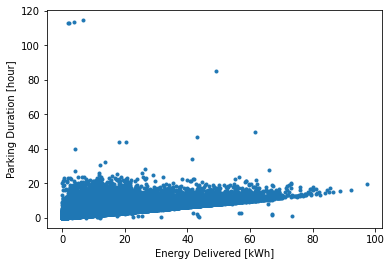

In [4]:
plt.scatter(df['Energy (kWh)'],df['ParkingTime'],marker='.')
plt.xlabel('Energy Delivered [kWh]')
plt.ylabel('Parking Duration [hour]')

In [19]:
df = pd.get_dummies(df,columns=['Longitude'])
df.drop(columns=['Latitude'],inplace=True)

In [20]:
df['day_of_week'] = df.index.weekday
df['hour_of_day'] = df.index.hour
df['month_of_year'] = df.index.month
df['weekend'] = df.index.weekday.isin([5,6])

df = pd.get_dummies(df, columns=['day_of_week', 'hour_of_day', 'month_of_year', 'weekend'])

df['hour_x'] = np.sin(np.radians((360/24)*df.index.hour))
df['hour_y'] = np.cos(np.radians((360/24)*df.index.hour))

df['month_x'] = np.sin(np.radians((360/24)*df.index.month))
df['month_y'] = np.cos(np.radians((360/24)*df.index.month))


In [21]:
df.head()

,Energy (kWh),ParkingTime,Longitude_-122.163239,Longitude_-122.163231,Longitude_-122.163139,Longitude_-122.163078,Longitude_-122.163048,Longitude_-122.163033,Longitude_-122.163017,Longitude_-122.16288,...,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,hour_x,hour_y,month_x,month_y
Start Date,,,,,,,,,,,,,,,,,,,,,
2011-07-29 20:17:00,6.249457,3.058889,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.866025,5.000000e-01,0.965926,-0.258819
2011-07-30 00:00:00,0.106588,0.035000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000000,1.000000e+00,0.965926,-0.258819
2011-07-30 08:16:00,14.951777,4.292222,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.866025,-5.000000e-01,0.965926,-0.258819
2011-07-30 14:51:00,7.159643,2.056667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.500000,-8.660254e-01,0.965926,-0.258819
2011-07-30 18:51:00,1.957765,1.190000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-1.000000,-1.836970e-16,0.965926,-0.258819


In [34]:
numeric_cols = ['Energy (kWh)'] + ['ParkingTime'] + ['hour_x'] + ['hour_y'] + ['month_x'] + ['month_y']
categorical_cols = [col for col in df.columns if col not in numeric_cols]

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


numerics = pd.DataFrame(sc.fit_transform(df[numeric_cols]),index=df.index, columns=numeric_cols)
categoricals = df[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)

In [39]:
H = 24
Y = pd.DataFrame(index=df.index)
for h in range(H):
    Y['h_'+ str(h)] = df['Energy (kWh)'].shift(-h)
    

In [41]:
X, Y = X.iloc[:-H,:], Y.iloc[:-H,:]

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [43]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [45]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, Y_train)

print(model.score(X_test, Y_test))